In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas_datareader as pdr
import stockstats
import datetime
import pandas as pd
import sys
sys.path.append('/localscratch/data/project_one/update/')
%load_ext autoreload
%autoreload 2
from updater import StockUpdater

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
dai = pdr.get_data_yahoo('DAI.DE',datetime.datetime(2010,1,1),datetime.datetime.today())

In [29]:
dai_cp = dai.copy(deep=True)
print dai.tail(5)
dai_cp = stockstats.StockDataFrame.retype(dai_cp)
print dai_cp.keys()

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2018-02-07  70.330002  71.180000  69.610001  70.650002  70.650002  5254476
2018-02-08  70.339996  71.089996  69.959999  70.330002  70.330002  5486222
2018-02-09  70.129997  70.849998  69.680000  70.129997  70.129997  7517673
2018-02-12  70.860001  71.559998  70.360001  70.970001  70.970001  4135182
2018-02-13  70.830002  70.910004  70.400002  70.620003  70.620003  1039964
Index([u'open', u'high', u'low', u'close', u'adj close', u'volume'], dtype='object')


In [30]:
def get_rsi(data,window=14):
    
    diff = data['Close'].diff(periods=1)
    dpm = pd.DataFrame()
    dnn = pd.DataFrame()
    dpm['Close'] = (diff+diff.abs())/2.
    dnn['Close'] = (-diff+diff.abs())/2.
    
    dpm_smma = get_smma(dpm,window=window)
    dnn_smma = get_smma(dnn,window=window)
    
    return 100. - 100./(1. + dpm_smma/dnn_smma)

def get_smma(raw_data,window,column='Close'):
      return raw_data[column].ewm(ignore_na=False,alpha=1./window,min_periods=0,adjust=True).mean()
    
def get_ema(rawData,window,column='Close'):
        return rawData[column].ewm(ignore_na=False,span=window,min_periods=0,adjust=True).mean()

def get_MACD(rawData,fast_window = 12,slow_window=26,signal_window=9):
        
        '''
        computation of moving average convergence/divergence
        
        Parameters
        ---------------
        
        rawData : pandas DataFrame must include 'Close' prize
        
        fast_window : int (default 12),fast window for exp. weighted moving average of closing prize
        
        slow_window : int (default 26), slow window for exp. weighted moving average of closing prize 

        '''
        fast = get_ema(rawData,window=fast_window)
        slow = get_ema(rawData,window=slow_window)
        
        out = pd.DataFrame(index=rawData.index)
        out['MACD'] = fast - slow
        out['MACDS'] = get_ema(out,window=signal_window,column='MACD')
        out['MACDH'] = (out['MACD'] - out['MACDS'])
                
        return out

def get_high_low_delta(rawData,windows=1,relative=False):
    '''
    get difference between daily high and low values within window range, respectively
            
    Parameters
    ---------------
    
    rawData : pandas DataFrame must include daily 'High' and 'Low' prize
    
    windows : int (default 1), window for taking the difference, e.g. window=2 takes the differences between every 2nd day
    
    relative : bool (default False) whether or not return the relative (or absolute) difference
    
    Returns
    ----------------
        
    out : pandas DataFrame contains high and low values (relative or absolute)
    
    '''
    if 'High' not in rawData.columns:
        raise ValueError('rawData does not contain column "High"')
    if 'Low' not in rawData.columns:
        raise ValueError('rawData does not contain column "Low"')
    
    out = pd.DataFrame(index=rawData.index)
    if relative == False:
        out['High'] = rawData['High'].diff(periods=windows)
        out['Low'] = rawData['Low'].diff(periods=windows)
    elif relative == True:
        out['High rel'] = rawData['High'].diff(periods=windows)/rawData['High']
        out['Low rel'] = rawData['Low'].diff(periods=windows)/rawData['Low']
        
    return out
  
def get_up_down_move(rawData,windows=1):
    '''
    To do
    
    Parameters
    -------------
    rawData : pandas DataFrame must include daily 'High' and 'Low' prize
    
    windows : int (default 1) window for getting the respective up and down moves of stock prize
    
    Returns
    -------------
    out : pandas DataFrame contains columns "up move" and "down move" for both moves respectively
    '''
    tmp =get_high_low_delta(rawData,windows=windows,relative=False)
    
    out = pd.DataFrame(index=rawData.index)
    out['up move'] = (tmp['High'] + tmp['High'].abs())/2.
    out['down move'] = (-tmp['Low'] + tmp['Low'].abs())/2.
    
    return out


def get_pdm_ndm(rawData,window):
    '''
    compute positive and negative directional moving average (negative directional moving accumulation)
    
    Parameters
    -------------
    rawData : pandas DataFrame must include daily 'High' and 'Low' prize
    
    window : int number of business days for computation of moving average
    
    Returns
    -------------
    out : pandas DataFrame contains columns "pdm" and "ndm" for positve (negative) directional moving average
    
    '''
    
    tmp = get_up_down_move(rawData)
    
    out = pd.DataFrame(index=rawData.index)
    out['PDM'] = np.where(tmp['up move']>tmp['down move'],tmp['up move'],0)
    out['NDM'] = np.where(tmp['down move']>tmp['up move'],tmp['down move'],0)
 
    if window>1:
        out['PDM'] = get_ema(out,window=window,column='PDM')
        out['NDM'] = get_ema(out,window=window,column='NDM')
        
    return out

def get_true_range(rawData):
    """
    compute true range
    
    Parameters
    -------------
    rawData : pandas DataFrame must include columns 'High', 'Low', 'Close'
    
    Returns
    -------------
    out : pandas DataFrame contains column "true range" 
    """
    
    prev_close = rawData['Close'].shift(periods=1)
    
    c1 = rawData['High'] - rawData['Low']
    c2 = np.abs(rawData['High'] - prev_close)
    c3 = np.abs(rawData['Low'] - prev_close)
    
    out = pd.DataFrame(index=rawData.index)
    out['true range'] = np.max((c1,c2,c3),axis=0)
    return out

def get_pdi_and_ndi(rawData,window):
    """
    compute positive directional moving index and negative directional moving index
    
    Parameters
    -------------
    rawData : pandas DataFrame must include columns 'High', 'Low', 'Close'
    
    Returns
    -------------   
    """
    
    tmp1 = get_pdm_ndm(rawData,window=window)
    tmp2 = get_average_true_range(rawData,window=window)
    
    out = pd.DataFrame(index=rawData.index)
    out['PDI'+str(window)] = tmp1['PDM']/tmp2['ATR'+str(window)] * 100.
    out['NDI'+str(window)] = tmp1['NDM']/tmp2['ATR'+str(window)] * 100.
    return out


def get_average_true_range(rawData,window=14,relative=False):
    """
    compute average true range (ATR) of stock 
    https://en.wikipedia.org/wiki/Average_true_range
    Parameters
    --------------
    rawData : pandas DataFrame must include columns 'High', 'Low', 'Close'
    
    window : int window size for smoothed average of true range values
    
    Returns
    -------------
    out : pandas DataFrame contains column "ATR"+window
    
    """
    
    trueRange = get_true_range(rawData)
    
    out = pd.DataFrame(index=rawData.index)
    if relative == False:
        out['ATR'+str(window)] = get_smma(trueRange,window=window,column='true range')
    elif relative == True:
        out['ATR'+str(window)] = get_smma(trueRange,window=window,column='true range')/rawData['Close']
    
    return out

def get_directional_movement_index(rawData,window):
    '''
    compute directional movement index (dx)
    
    Parameters
    ------------
    rawData : pandas DataFrame must include columns 'High', 'Low', 'Close'
    
    window : int window size to compute directional movement index
    
    Returns
    ------------
    out : pandas DataFrame 
    
    '''
    tmp = get_pdi_and_ndi(rawData,window=window)
    
    out = pd.DataFrame(index=rawData.index)
    out['DX'+str(window)] = 100*(tmp['PDI'+str(window)] - tmp['NDI'+str(window)]).abs()/(tmp['PDI'+str(window)] + tmp['NDI'+str(window)])
    return out


def get_adx(rawData,window_adx=6,window_dx = 14):
    '''
    compute averaged directional movement index
    
    Parameters
    ------------
    rawData : pandas DataFrame must include columns 'High', 'Low', 'Close'
    
    window_dx : int (default 14) window size to compute directional movement index
    
    window_adx : int (default 6) window size to compute averaged dx
    
    Returns
    -------------
    out : pandas DataFrame
    
    '''
    
    tmp = get_directional_movement_index(rawData,window=window_dx)
    
    out = pd.DataFrame(index=rawData.index)
    out['ADX'+str(window_adx)+'_'+str(window_dx)] = get_ema(tmp,window=window_adx,column='DX'+str(window_dx))
    out['ADXR'] = get_ema(out,window=window_adx,column='ADX'+str(window_adx)+'_'+str(window_dx))
    return out
    
    
def get_raw_stochastic_value(rawData,window):
    '''
    compute raw stochastic value for given window
    
    '''
    low_min = rawData['Low'].rolling(min_periods=1,window=window,center=False).min()
    high_max = rawData['High'].rolling(min_periods=1,window=window,center=False).max()
    
    out = pd.DataFrame(index=rawData.index)
    out['RSV'+str(window)] = (rawData['Close'] - low_min) /(high_max - low_min) * 100
    #out['RSV'+str(window)].fillna(0).astype('float64')
    
    return out

def get_cci(rawData,window=20):
    
    TP = (rawData['Close'] + rawData['High'] + rawData['Low']) / 3.0
    
    TP_SMA = TP.rolling(min_periods=1,window = window,center=False).mean()
    
    mean_dev = TP.rolling(min_periods=1, center=False, window=window).apply(lambda x: np.fabs(x - x.mean()).mean())
    
    out = pd.DataFrame(index=rawData.index)
    
    out['CCI'+str(window)] = (TP - TP_SMA)/(.015*mean_dev)
    return out
    
    
#low_min = df['low'].rolling(
# min_periods=1, window=n_days, center=False).min()
# high_max = df['high'].rolling(
#            min_periods=1, window=n_days, center=False).max()

# cv = (df['close'] - low_min) / (high_max - low_min)
#df[column_name] = cv.fillna(0).astype('float64') * 100

In [24]:
out = get_cci(dai,20)

print out.tail(5)

print dai_cp['cci_20'].tail(5)
#out2= get_adx(dai,window_adx=6,window_dx=14)
#print out.tail(5)

#plt.plot(out.index,out['ADX10_10'])
#plt.show()

#plt.plot(out.index,out['ADXR'])

#plt.show()

#print dai_cp['adxr'].tail(5)

#plt.plot(out.index,out['ATR14'])
#plt.show()


#print dai_cp['dx_14'].tail(5)
#print dai_cp['mdi_14'].tail(5)
#get_up_down_move(dai)['down move']
#tmp = get_pdm_ndm(dai,window=10)
#print tmp['pdm'].tail(10)
#plt.plot(x.index,x['MACDH'].values)


#plt.show()
#print dai.loc[pd.isna(dai).any(axis=1)]
#tmp = get_rsi(dai,window=14)
#plt.plot(tmp.index,tmp.values)
#plt.show()
#print get_smma(raw_data=dai,window=14).head(5)
#sys.exit()
#print dai['Close'].diff(periods=1).head(2)
#print dai['Close'][1:].values - dai['Close'][0:-1].values
#print dai['Close'][0:-1].head(5)
#print dai_cp['rsi_14']


                 CCI20
Date                  
2018-02-07 -152.214016
2018-02-08 -125.360880
2018-02-09 -113.838134
2018-02-12  -75.835676
2018-02-13  -77.450984
Date
2018-02-07   -152.214016
2018-02-08   -125.360880
2018-02-09   -113.838134
2018-02-12    -75.835676
2018-02-13    -77.450984
Name: cci_20, dtype: float64


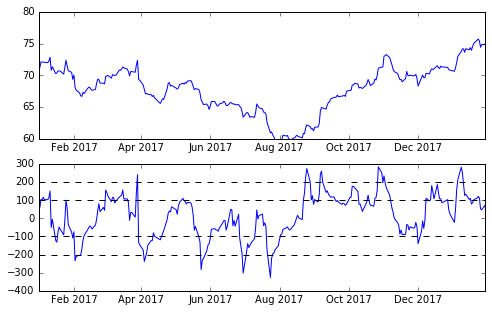

In [43]:
ob = StockUpdater(PathData='/localscratch/data/project_one/data/')
#ob.update_chart_markers(ListOfTickers=['DAI.DE'])
out = ob._get_cci(dai,window=40)
out2 = ob._get_cci(dai,window=20)
tmp = dai_cp['cci_20']

fig,ax = plt.subplots(2,1,figsize=(8,5))

ax[0].plot(dai.index,dai['Close'])
#ax[1].plot(out.index,out['CCI40'])
ax[1].plot(out.index,out2['CCI20'])
#plt.plot(tmp.index,tmp.values)
ax[0].set_xlim(datetime.datetime(2017,1,1),datetime.datetime(2018,1,29))
ax[0].set_ylim(60,80)
ax[1].set_xlim(datetime.datetime(2017,1,1),datetime.datetime(2018,1,29))
ax[1].axhline(100,color='k',ls='--')
ax[1].axhline(200,color='k',ls='--')
ax[1].axhline(-100,color='k',ls='--')
ax[1].axhline(-200,color='k',ls='--')
plt.show()

In [ ]:
tmp = ob._get_rsi(dai,7)
plt.plot(tmp.index,tmp.values)
tmp = ob._get_rsi(dai,14)
plt.plot(tmp.index,tmp.values)
tmp = ob._get_rsi(dai,25)

plt.plot(tmp.index,tmp.values)

plt.show()



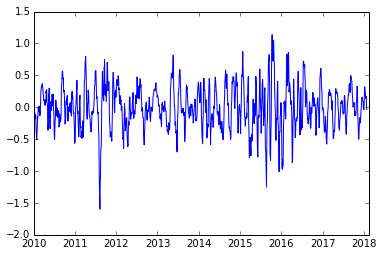

           Date      MACD
4551 2018-01-23  0.173016
4552 2018-01-24  0.141282
4553 2018-01-25  0.038779
4554 2018-01-26 -0.010258
4555 2018-01-29 -0.034678


In [16]:
test = pd.read_pickle('/home/fabian/project_one/data/chart/stocks/DAI.DE.p')
plt.plot(test['Date'],test['MACD'])
plt.xlim(datetime.datetime(2010,1,1),datetime.datetime.today())
plt.show()

print test[['Date','MACD']].tail(5)